<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Feature_selection_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar  4 16:52:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# memory management
import gc
import re
import timeit #pour mesurer le temps déxécution
#permet de stocker notre modéle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# modeling 
import lightgbm as lgb
import sklearn.metrics as me
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV 
#pour avoir le tableau f1,precision
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.metrics import classification_report

In [3]:
def Histo(colonne,base,bines):
  sns.displot(x=colonne,data=base, kde=False, bins=bines,color="darkblue")
  plt.grid()

In [4]:
def conf_mat_transform(y_test,y_pred) :
    conf_mat = me.confusion_matrix(y_test,y_pred)
    
    corresp = np.argmax(conf_mat,axis=0) 
    #vu quon a un numero de colonne de
    #la valeur max les meme pour deux lignes on le fait manuellement
    #on na pas des accuracy proche de 1 on pouvait utiliser le argmax
    #corresp = [0, 3, 6, 4, 2, 1, 5]
    #print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_test, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [5]:
#https://www.youtube.com/watch?v=zPEaC_yvL_k
#make_scorer
#https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
#beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

# Determines the weight of recall in the combined score.

def customScore(y_test, y_pred):

  beta=0.7 #Try to give more weight on FN 
  logi_confusion = me.confusion_matrix(y_test, y_pred) 
  tn, fp, fn, tp = logi_confusion.ravel()
  alpha=beta*fn+(1-beta)*fp
  return  alpha
 

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/p7/data/NEW_data.csv')

In [ ]:
data = df[df['TARGET'].notnull()]
del df
gc.collect()

In [ ]:
data.to_csv('/content/drive/MyDrive/p7/data/NEW_data_data.csv', index=False)

## **Random Forest**

 http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704

In [73]:
data= pd.read_csv('/content/drive/MyDrive/p7/data/NEW_data_data.csv')

In [74]:
data.drop(['Unnamed: 0'], axis=1,inplace=True)

**Imputation**

In [76]:
# data missing values (in percent)
data_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
data_missing.head()

BURO_NEW_FLAG_nan_MEAN_MEAN    0.749487
BURO_MONTHS_BALANCE_MIN_MIN    0.749487
BURO_STATUS_2_MEAN_MEAN        0.749487
BURO_STATUS_1_MEAN_MEAN        0.749487
BURO_STATUS_0_MEAN_MEAN        0.749487
dtype: float64

In [77]:
# Identify missing values above threshold
data_missing = data_missing.index[data_missing > 0.5]

print('There are %d columns with more than 50%% missing values' % len(data_missing))

There are 78 columns with more than 50% missing values


In [78]:
data_clean = data.drop(columns = data_missing)

print('data_clean set full shape: ', data_clean.shape)

data_clean set full shape:  (307505, 561)


In [11]:
data_clean.isnull().sum().sort_values(ascending=False)

CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN     153541
CLOSED_AMT_CREDIT_SUM_MEAN             153541
CLOSED_DAYS_CREDIT_MIN                 153541
CLOSED_DAYS_CREDIT_MAX                 153541
CLOSED_DAYS_CREDIT_MEAN                153541
                                        ...  
ORGANIZATION_TYPE_Industry: type 2          0
ORGANIZATION_TYPE_Industry: type 13         0
ORGANIZATION_TYPE_Industry: type 12         0
ORGANIZATION_TYPE_Industry: type 11         0
TARGET                                      0
Length: 560, dtype: int64

In [79]:
data_clean[data_clean==np.inf]=np.nan

In [80]:
# Imputaion with mod & median
def filling_nan_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    df[column]= df[column].fillna(df[column].median())
  return (df)

In [81]:
data_clean = filling_nan_value(data_clean)

In [15]:
data_clean.isnull().sum().sort_values(ascending=False).head()

TARGET                                                  0
PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN    0
PREV_NAME_CLIENT_TYPE_Refreshed_MEAN                    0
PREV_NAME_CLIENT_TYPE_Repeater_MEAN                     0
PREV_NAME_CLIENT_TYPE_nan_MEAN                          0
dtype: int64

In [82]:
gc.enable()
del data 
gc.collect()

474

**Spliting**

In [83]:
X= data_clean.drop(['TARGET'],axis=1).copy()
y = data_clean['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.3,random_state=0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (215253, 560)
The shape of X_test is (92252, 560)
The shape of y_train is (215253,)
The shape of y_test is (92252,)


In [84]:
del X,y

In [85]:
X_train.head(3)

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
115232,233633,1,1,0,0,180000.0,312840.0,8964.0,0.016612,-13424,...,14395.347321,806139.450,4808.880,139500.810,17510.745536,980601.750,-576.0,-1590.732143,-89081.0,56.0
113005,231071,0,1,1,0,126000.0,49752.0,5355.0,0.019689,-8842,...,479283.817500,1917135.270,47497.545,1774642.635,479283.817500,1917135.270,-976.0,-1017.250000,-4069.0,4.0
132492,253675,0,0,1,1,157500.0,150948.0,13972.5,0.025164,-11194,...,18874.792500,113248.755,18779.805,18893.790,18874.792500,113248.755,-674.0,-730.000000,-4380.0,6.0


In [86]:
X_train_tr= X_train.drop('SK_ID_CURR', axis=1)
X_test_ts= X_test.drop('SK_ID_CURR', axis=1)

**standard scaler**

In [87]:
std_scale=RobustScaler().fit(X_train_tr)
#entrainement sur le train

In [89]:
X_scale_train= std_scale.transform(X_train_tr)
#transformation du train
X_scale_test= std_scale.transform(X_test_ts)
#transformation du test

In [21]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

In [90]:
! pip install boruta

     |████████████████████████████████| 56 kB 4.2 MB/s 


In [91]:
from boruta import BorutaPy
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=4242, max_iter = 50, perc = 90)


In [92]:
boruta_feature_selector.fit(X_scale_train, y_train)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	559
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	84
Tentative: 	117
Rejected: 	358
Iteration: 	9 / 50
Confirmed: 	84
Tentative: 	117
Rejected: 	358
Iteration: 	10 / 50
Confirmed: 	84
Tentative: 	117
Rejected: 	358
Iteration: 	11 / 50
Confirmed: 	84
Tentative: 	117
Rejected: 	358
Iteration: 	12 / 50
Confirmed: 	84
Tentative: 	86
Rejected: 	389
Iteration: 	13 / 50
Confirmed: 	84
Tentative: 	86
Rejected: 	389
Iteration: 	14 / 50
Confirmed: 	84
Tentative: 	86
Rejected: 	389
Iteration: 	15 / 50
Confirmed: 	84
Tentative: 	86
Rejected: 	389
Iteration: 	16 / 50
Confirmed: 	84
Tentative

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=289, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F293EFFE490),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x7F293EFFE490, verbose=2)

In [93]:
X_filtered = boruta_feature_selector.transform(X_scale_train)
X_filtered.shape

(215253, 84)

In [95]:
X_filtered

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ..., -1.,  0.,  1.],
       [-1.,  0.,  1., ..., -1.,  0.,  1.],
       ...,
       [ 0.,  0.,  2., ..., -1.,  0.,  1.],
       [ 0.,  0.,  0., ..., -1.,  0.,  1.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.]])

In [96]:
features = [f for f in data_clean.columns if f not in ['TARGET','SK_ID_CURR']]
len(features)

559

In [97]:
final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])

In [98]:
len(final_features)

84

In [106]:
df_X_train_rf =X_train[final_features]
df_X_test_rf =X_test[final_features]

In [ ]:
df_X_train_rf= df_X_train_rf.append(X_train['SK_ID_CURR'])

In [1]:
df_X_train_rf

NameError: ignored

In [100]:
df_X_train_rf.shape

(215253, 84)

In [101]:
df_X_test_rf.shape

(92252, 84)

In [103]:
df_X_train_rf.head()


,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NEW_REVOLVING_LOANS_1.0,NEW_HAS_CAR_0.0,NEW_HAS_CAR_1.0,NEW_HAS_COMPANY_0.0,NEW_HAS_COMPANY_1.0,NEW_LABORERS_0.0,NEW_LABORERS_1.0,NEW_AGE_SEGMENT_MİDDLE,NEW_AGE_SEGMENT_OLD,NEW_AGE_SEGMENT_YOUNG
115232,1,1,0,180000.0,312840.0,8964.0,0.016612,-13424,-5143.0,-593.0,...,0,0,1,0,1,1,0,1,0,0
113005,0,1,0,126000.0,49752.0,5355.0,0.019689,-8842,-1130.0,-3723.0,...,0,0,1,1,0,0,1,0,0,1
132492,0,0,1,157500.0,150948.0,13972.5,0.025164,-11194,-1441.0,-3626.0,...,0,1,0,0,1,1,0,0,0,1
18531,1,1,0,112500.0,319500.0,16312.5,0.035792,-15764,-4899.0,-7791.0,...,0,0,1,1,0,1,0,1,0,0
234349,1,0,0,225000.0,387000.0,14031.0,0.026392,-21481,-1648.0,-7445.0,...,0,1,0,1,0,1,0,0,1,0


In [ ]:
df_X_train_rf.to_csv('/content/drive/MyDrive/p7/data/df_X_train_rf.csv', index=False)
df_X_test_rf.to_csv('/content/drive/MyDrive/p7/data/df_X_test_rf.csv', index= False)

In [47]:
df_X_train_rf= pd.read_csv('/content/drive/MyDrive/p7/data/df_X_train_rf.csv')

In [23]:
df_X_test_rf= pd.read_csv('/content/drive/MyDrive/p7/data/df_X_test_rf.csv')

In [48]:
df_X_train_rf.head()

,Unnamed: 0,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,NEW_REVOLVING_LOANS_1.0,NEW_HAS_CAR_0.0,NEW_HAS_CAR_1.0,NEW_HAS_COMPANY_0.0,NEW_HAS_COMPANY_1.0,NEW_LABORERS_0.0,NEW_LABORERS_1.0,NEW_AGE_SEGMENT_MİDDLE,NEW_AGE_SEGMENT_OLD,NEW_AGE_SEGMENT_YOUNG
0,115232,1,1,0,180000.0,312840.0,8964.0,0.016612,-13424,-5143.0,...,0,0,1,0,1,1,0,1,0,0
1,113005,0,1,0,126000.0,49752.0,5355.0,0.019689,-8842,-1130.0,...,0,0,1,1,0,0,1,0,0,1
2,132492,0,0,1,157500.0,150948.0,13972.5,0.025164,-11194,-1441.0,...,0,1,0,0,1,1,0,0,0,1
3,18531,1,1,0,112500.0,319500.0,16312.5,0.035792,-15764,-4899.0,...,0,0,1,1,0,1,0,1,0,0
4,234349,1,0,0,225000.0,387000.0,14031.0,0.026392,-21481,-1648.0,...,0,1,0,1,0,1,0,0,1,0


In [ ]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

In [24]:
rf.fit(df_X_train_rf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [ ]:
rf_feature_imp = rf.feature_importances_

In [ ]:
feature_importances = pd.DataFrame({'feature': list(df_X_train_rf.columns), 'importance': rf_feature_imp}).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
37,NEW_EXT_MEAN,0.340158
18,EXT_SOURCE_2,0.157356
19,EXT_SOURCE_3,0.153191
8,DAYS_EMPLOYED,0.034694
79,NEW_LABORERS_0.0,0.030279
80,NEW_LABORERS_1.0,0.030118
7,DAYS_BIRTH,0.024821
38,NEW_AGE,0.024130
32,NEW_DAYS_EMPLOYED_PERC,0.023423
46,NAME_EDUCATION_TYPE_Higher education,0.021492


In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

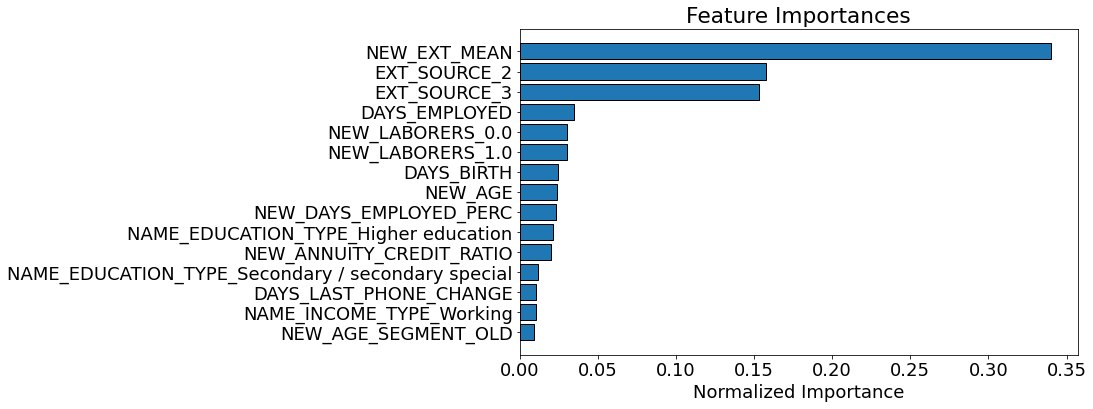

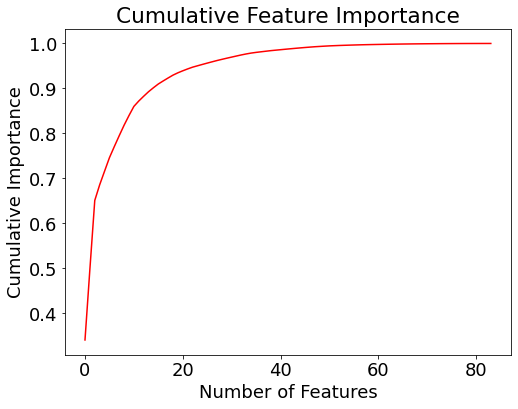

15 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 0 features with 0.0 importance


,feature,importance
63,ORGANIZATION_TYPE_Self-employed,0.000069
11,FLAG_WORK_PHONE,0.000066
60,OCCUPATION_TYPE_Sales staff,0.000059
52,NAME_HOUSING_TYPE_With parents,0.000049
65,FONDKAPREMONT_MODE_reg oper account,0.000048
50,NAME_FAMILY_STATUS_Widow,0.000027
58,OCCUPATION_TYPE_Low-skill Laborers,0.000025
56,OCCUPATION_TYPE_High skill tech staff,0.000023
29,FLAG_DOCUMENT_6,0.000015
59,OCCUPATION_TYPE_Managers,0.000013


**Model Prediction**

In [ ]:
df1=pd.DataFrame()
df1['predict']=rf.predict_proba(df_X_test_rf)[:,1]

Text(0.5, 1.0, "Graphique des probabibilités d'affectation")

<Figure size 432x288 with 0 Axes>

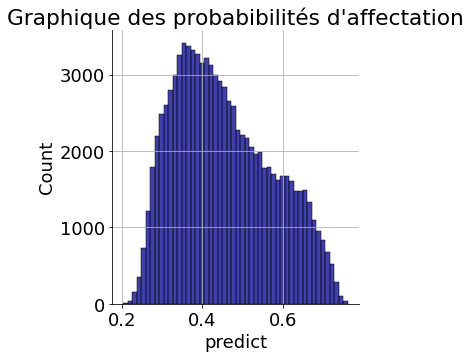

In [ ]:
plt.figure()
Histo('predict', df1, 50)
plt.title('Graphique des probabibilités d\'affectation')

In [ ]:
#prédiction
#y_pred = model_best.predict(X_scale_test)
#on va prendre la deuxieme colonne qui est le score de présence 
#model_best.predict_proba(X_scale_test)[:,1]>0.5
r=rf.predict_proba(df_X_test_rf)[:,1]
y_predr=np.array(r>0.3,dtype=int)

Text(0.5, 1.0, "Graphique des probabibilités d'affectation Random Forest")

<Figure size 432x288 with 0 Axes>

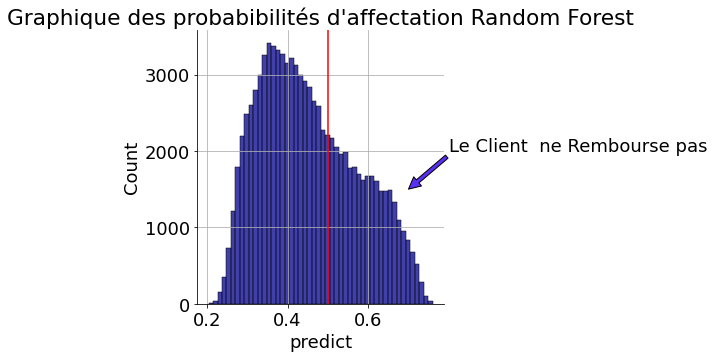

In [ ]:
plt.figure()
Histo('predict', df1, 50)
plt.axvline(x=0.5, color='red')
plt.annotate('Le Client  ne Rembourse pas',xy=(0.7,1500),xytext=(0.8,2000),arrowprops=
             {'facecolor':'#5930F2'})
plt.title('Graphique des probabibilités d\'affectation Random Forest')

In [ ]:
logi_confusion = me.confusion_matrix(y_test, y_predr)

In [ ]:
cls_labels_transform = conf_mat_transform(y_test, y_predr)
conf_mat = me.confusion_matrix(y_test, y_predr)
print(conf_mat)
print()
print(me.classification_report(y_test, y_predr))
#accuracy =precision la plus part sont prédits positifs et le sont effectivement
#recall=sensibilte taux de vrais positifs 
#specifite =taux de varais negatifs

[[ 7882 76994]
 [  131  7245]]

              precision    recall  f1-score   support

         0.0       0.98      0.09      0.17     84876
         1.0       0.09      0.98      0.16      7376

    accuracy                           0.16     92252
   macro avg       0.53      0.54      0.16     92252
weighted avg       0.91      0.16      0.17     92252



Text(16.0, 0.5, 'Predict')

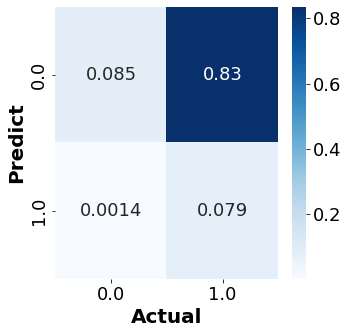

In [ ]:
df_cm = pd.DataFrame(conf_mat/y_test.shape[0], index = [label for label in data_clean['TARGET'].value_counts().index ],
                  columns = [i for i in data_clean['TARGET'].value_counts().index ])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel('Actual',fontsize = 20, fontweight = 'bold')
plt.ylabel('Predict',fontsize = 20, fontweight = 'bold')

In [ ]:
score_rf = make_scorer(customScore ,greater_is_better = True)
#création de notre propre score grace à make_scorer
score_rf

make_scorer(customScore)

In [ ]:
score_random=customScore(y_test, y_predr)
#notre scorer
score_random

23189.900000000005

In [ ]:
precisionRandom= accuracy_score(y_test, y_predr)
precisionRandom

0.16397476477474743

In [ ]:
rappel_random=recall_score(y_test, y_predr)
rappel_random

0.9822396963123644

,thr,tpr,fpr
0,1.760252,0.000000,0.000000
1,0.760252,0.000000,0.000012
2,0.758987,0.000000,0.000024
3,0.758773,0.000136,0.000024
4,0.758740,0.000136,0.000035
...,...,...,...
12700,0.240407,0.999729,0.996784
12701,0.240407,0.999864,0.996784
12702,0.237963,0.999864,0.997420
12703,0.237953,1.000000,0.997420


AUC : 0.7358852787054209


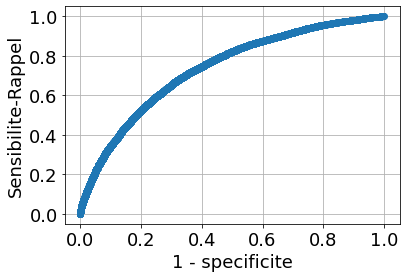

In [ ]:
from sklearn.metrics import roc_auc_score
[fpr, tpr, thr]  = me.roc_curve(y_test, rf.predict_proba(df_X_test_rf)[:, 1])
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
AUROCRandom=roc_auc_score(y_test, rf.predict_proba(df_X_test_rf)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, rf.predict_proba(df_X_test_rf)[:, 1])))

In [ ]:
AUROCRandom

0.7358852787054209

In [ ]:
# indice du premier seuil pour lequel
#Taux de faux négatifs + taux de vrais positifs (sensibilité=rappel)=1
#on pose taux de faux negatifs =0.05 (5%)
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 0.95
Spécificité : 0.22
Seuil : 0.34


In [ ]:
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

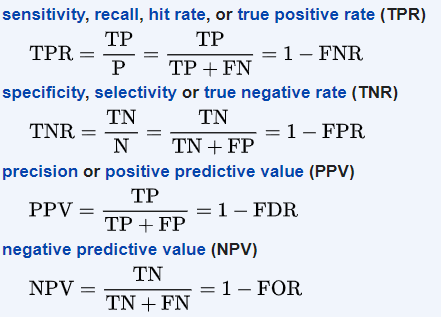

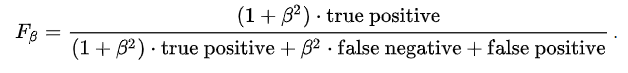

To reduce thhe risk of predicting true for defaulter client we decide to increase the coefficient of beta for giving more waight to recall.

In [ ]:
f1_score_rf = fbeta_score(y_test, y_predr, beta=1)
f5_score_rf = fbeta_score(y_test, y_predr, beta=5)
f10_score_rf = fbeta_score(y_test, y_predr, beta=10)

In [ ]:
c = fbeta_score(y_test, y_predr, beta=100)

In [ ]:
c

0.9812173025440752

In [ ]:
print('f1 score:',f1_score_rf)
print('f5 score:',f5_score_rf)
print('f10 score:',f10_score_rf)

f1 score: 0.15816187305572232
f5 score: 0.7012012403262371
f10 score: 0.8903751221346274


In [ ]:
result2=pd.DataFrame({'index' : [2], 'Model': ['RandomForest'],'Score':[score_random/100], 'f1': [f1_score_rf*100], 
                        'f5': [f5_score_rf*100], 'f10': [f10_score_rf*100],
                      'AUROC':[AUROCRandom*100],'Precision':[precisionRandom*100],'Recall':[rappel_random*100]})

In [ ]:
result2

,index,Model,Score,f1,f5,f10,AUROC,Precision,Recall
0,2,RandomForest,231.899,15.816187,70.120124,89.037512,73.588528,16.397476,98.22397


In [ ]:
result2.to_csv('/content/drive/MyDrive/p7/data/result_RF.csv', index=False)

In [ ]:
result1=pd.read_csv('/content/drive/MyDrive/p7/data/result_LightGBM.csv')

In [ ]:
result3=pd.read_csv('/content/drive/MyDrive/p7/data/result_XGB.csv')

In [ ]:
r= result1.append(result2)
r= r.append(result3)

In [ ]:
r

,Model,Score,f1,f5,f10,AUROC,Precision,Recall
0,LightGBM,88.850,27.123151,59.728048,64.528151,76.032547,71.480293,0.663774
0,RandomForest,231.899,15.816187,70.120124,89.037512,73.588528,16.397476,98.223970
0,XG Boost,78.293,28.332197,54.605292,57.929509,75.847946,76.062308,0.591784


In [ ]:
r.drop('index', axis=1, inplace=True)

In [ ]:
comparaison_score_melt = pd.melt(r.reset_index(), id_vars = ['Model'], value_name = 'Comparaison',\
                                 value_vars=['Score','f1', 'f5','f10','AUROC', 'Precision','Recall'])
#Annulez le pivotement d'un DataFrame du format large au format long, 
#en laissant éventuellement les identifiants définis

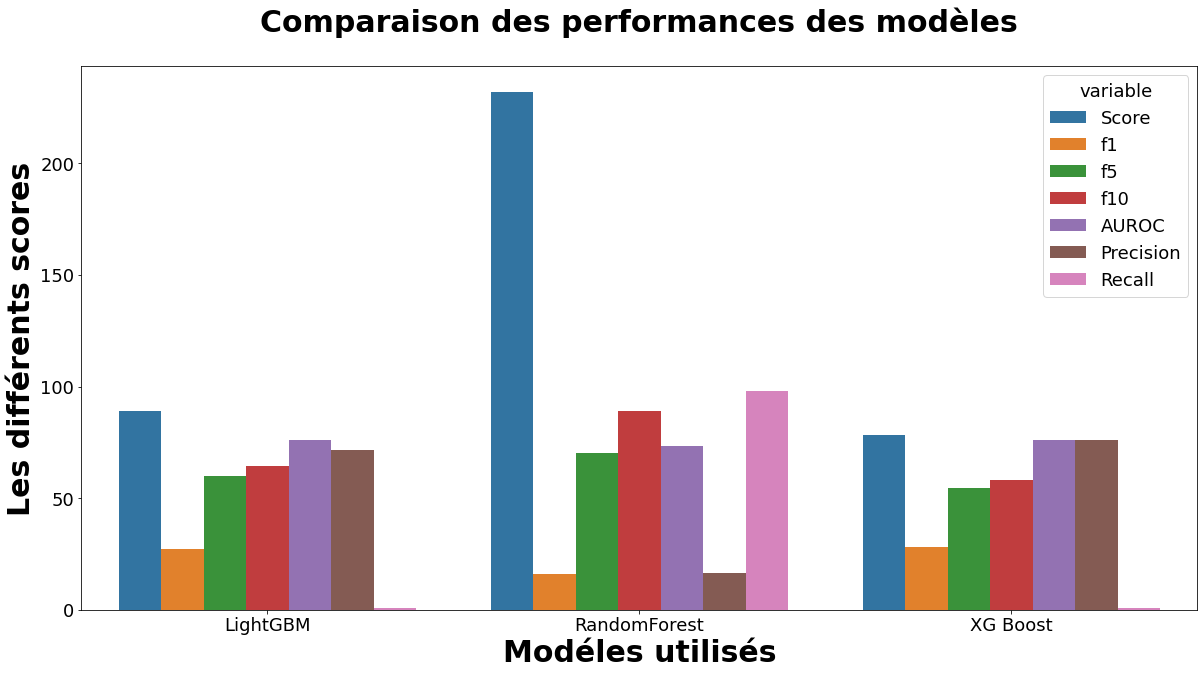

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['Comparaison'], hue = comparaison_score_melt['variable']);
plt.xlabel('Modéles utilisés',fontsize = 30, fontweight = 'bold')  
plt.ylabel('Les différents scores',fontsize = 30, fontweight = 'bold')          
plt.title('Comparaison des performances des modèles',fontsize = 30, pad = 35, fontweight = 'bold');

Selecting Random Forest Model for higher scoring and AUC_COR

In [ ]:
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

In [ ]:
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

In [54]:
df_X_test_rf.drop('Unnamed: 0', axis=1, inplace= True)
df_X_train_rf.drop('Unnamed: 0', axis=1, inplace= True)

In [40]:
df_X_test_rf.shape

(92252, 84)

In [46]:
df_X_test_rf.head()

,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NEW_REVOLVING_LOANS_1.0,NEW_HAS_CAR_0.0,NEW_HAS_CAR_1.0,NEW_HAS_COMPANY_0.0,NEW_HAS_COMPANY_1.0,NEW_LABORERS_0.0,NEW_LABORERS_1.0,NEW_AGE_SEGMENT_MİDDLE,NEW_AGE_SEGMENT_OLD,NEW_AGE_SEGMENT_YOUNG
0,0,1,0,135000.0,654498.0,31486.5,0.018634,-19240,-3441.0,-1734.0,...,0,0,1,1,0,1,0,1,0,0
1,1,1,1,135000.0,270000.0,13500.0,0.020246,-15653,-1026.0,-3103.0,...,1,0,1,1,0,1,0,1,0,0
2,0,0,1,94500.0,180000.0,9000.0,0.025164,-8206,-781.0,-3051.0,...,1,1,0,1,0,0,1,0,0,1
3,0,1,0,360000.0,1312110.0,55593.0,0.018850,-13903,-2632.0,-1081.0,...,0,0,1,0,1,1,0,1,0,0
4,0,0,0,450000.0,675000.0,26284.5,0.026392,-11082,-1630.0,-2839.0,...,0,1,0,1,0,1,0,0,0,1


In [55]:
df_X_train_rf.head()

,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NEW_REVOLVING_LOANS_1.0,NEW_HAS_CAR_0.0,NEW_HAS_CAR_1.0,NEW_HAS_COMPANY_0.0,NEW_HAS_COMPANY_1.0,NEW_LABORERS_0.0,NEW_LABORERS_1.0,NEW_AGE_SEGMENT_MİDDLE,NEW_AGE_SEGMENT_OLD,NEW_AGE_SEGMENT_YOUNG
0,1,1,0,180000.0,312840.0,8964.0,0.016612,-13424,-5143.0,-593.0,...,0,0,1,0,1,1,0,1,0,0
1,0,1,0,126000.0,49752.0,5355.0,0.019689,-8842,-1130.0,-3723.0,...,0,0,1,1,0,0,1,0,0,1
2,0,0,1,157500.0,150948.0,13972.5,0.025164,-11194,-1441.0,-3626.0,...,0,1,0,0,1,1,0,0,0,1
3,1,1,0,112500.0,319500.0,16312.5,0.035792,-15764,-4899.0,-7791.0,...,0,0,1,1,0,1,0,1,0,0
4,1,0,0,225000.0,387000.0,14031.0,0.026392,-21481,-1648.0,-7445.0,...,0,1,0,1,0,1,0,0,1,0


**Model deployment**

In [56]:
std_scale=RobustScaler().fit(df_X_train_rf)
#entrainement sur le train

In [57]:
X_scale_train=std_scale.transform(df_X_train_rf)
#transformation du train
X_scale_test=std_scale.transform(df_X_test_rf)
#transformation du test

In [26]:
import pickle

In [60]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

In [62]:
rf.fit(X_scale_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [63]:
#enrégistrer le modele pour pouvoir l'utiliser dans notre web application
pickle.dump(rf,open('credit.pkl','wb'))

In [64]:
#Calcul de la probabilité 
proba=rf.predict_proba(X_scale_test)[:,1]

In [66]:
df=pd.DataFrame()
df['predict']=proba

Text(0.5, 1.0, "Graphique des probabibilités d'affectation Random Forest")

<Figure size 432x288 with 0 Axes>

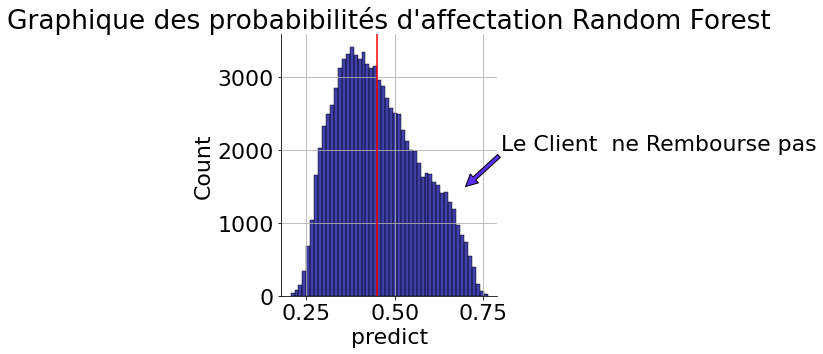

In [71]:
plt.figure()
Histo('predict',df,50)
plt.axvline(x=0.45, color='red')
plt.annotate('Le Client  ne Rembourse pas',xy=(0.7,1500),xytext=(0.8,2000),arrowprops=
             {'facecolor':'#5930F2'})
plt.title('Graphique des probabibilités d\'affectation Random Forest')

In [ ]:
#alignement des deux tables 
X, TEST_Final = data.align(TEST_Final, join = 'inner', axis=1)

In [72]:
TEST_Final['Score']=proba

NameError: ignored